# **Gradient Boosting Machines(GBMs) with XGBoost and LightGBM**
 The folowing topics are covered in this tutorial:



*   Downloading a real-world dataset from a kaggle competition
*   Performing feature engineering and prepare the dataset for training
*   Training and interpreting a gradient boosting model using XGBoost
*   Training with KFold cross validation and ensembling results
* Configuring the gradient boosting model and tuning hyperparameters.





In [2]:
!pip list | grep xgboost

xgboost                          2.0.3


In [3]:
!pip install opendatasets --upgrade --quiet

# **Problem Statement**
We'll learn gradient boosting by applying it a real-world dataset from the Rosssmann Store Slaes competition on Kaggle:

> Rossmann operates over 3,000 drug stores  in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition school and state holidays, seasonally and locality.

>With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

# **Downloading the Data**

We can download the dataset from Kaggle using the `opendatasets`

In [4]:
import os
import opendatasets as od
import pandas as pd
pd.set_option("display.max_columns",120)
pd.set_option("display.max_rows",120)

In [5]:
od.download('https://www.kaggle.com/c/rossmann-store-sales')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rumerodgers
Your Kaggle Key: ··········


100%|██████████| 6.99M/6.99M [00:00<00:00, 54.1MB/s]


Extracting archive ./rossmann-store-sales/rossmann-store-sales.zip to ./rossmann-store-sales


In [6]:
os.listdir('rossmann-store-sales')

['sample_submission.csv', 'store.csv', 'test.csv', 'train.csv']

Let's load the data into pandas dataframes.

In [7]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)

In [8]:
store_df = pd.read_csv('./rossmann-store-sales/store.csv')

In [9]:
test_df = pd.read_csv('./rossmann-store-sales/test.csv')

In [10]:
submission_df = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

In [11]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [12]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [13]:
submission_df

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
41083,41084,0
41084,41085,0
41085,41086,0
41086,41087,0


In [14]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


Let's merge the information from `store_df` into `train_df` and `test_df`.

In [15]:
merged_df = ross_df.merge(store_df, how = 'left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [16]:
merged_df.Date

0          2015-07-31
1          2015-07-31
2          2015-07-31
3          2015-07-31
4          2015-07-31
              ...    
1017204    2013-01-01
1017205    2013-01-01
1017206    2013-01-01
1017207    2013-01-01
1017208    2013-01-01
Name: Date, Length: 1017209, dtype: object

In [17]:
merged_test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


> **EXERCISE:**Perform exploratory data analysis and visualization on the dataset. Study the distribution of values in each column, and their relationship with the target column `Sales`.

# **Preprocessing and  Feature Engineering**

In [18]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

##**Date**

Conduct **Feature Engineering** by splitting the date to day of the week, date, year and month so that the model can capture monthly/weekly/daily patterns.

In [19]:
def split_date(df):
  df['Date']=pd.to_datetime(df.Date)
  df['Year']=df.Date.dt.year
  df['Month']=df.Date.dt.month
  df['Day']=df.Date.dt.day
  df['WeekofYear']=df.Date.dt.isocalendar().week

In [20]:
split_date(merged_df)
split_date(merged_test_df)

In [21]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekofYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


## **Store Open/Closed**

Next, notice that the sales are zero whenever the store is closed.

In [22]:
merged_df[merged_df.Open==0].Sales.value_counts()

Sales
0    172817
Name: count, dtype: int64

Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. Train a model which for data when the store is open making it easier for the model to learn other relationships.

We can set the Sales to zero if the store is closed.

 We won't remove rows from the test set, since we need to make predictions for every row.

In [23]:
merged_df= merged_df[merged_df.Open==1].copy()
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekofYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN,2013,1,1,1
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


## **Competition**

Next, we can use the columns `CompetitionOpenSince[Month/Year]` columns from `store_df` to compute the number of months for which a competitor has been open near the store.

In [24]:
def comp_months(df):
  df['CompetitionOpen'] = 12*(df.Year -df.CompetitionOpenSinceYear)+(df.Month - df.CompetitionOpenSinceMonth)
  df['CompetitionOpen']= df['CompetitionOpen'].map(lambda x: 0 if x<0 else x).fillna(0)#Replaces the -ve values with zero

In [25]:
#merged_df.sample(10)

In [26]:
comp_months(merged_df)
comp_months(merged_test_df)

Lt's view the results of the new columns we've created.

In [27]:
merged_df[['Date','CompetitionDistance','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']]

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth
0,2015-07-31,1270.0,2008.0,9.0
1,2015-07-31,570.0,2007.0,11.0
2,2015-07-31,14130.0,2006.0,12.0
3,2015-07-31,620.0,2009.0,9.0
4,2015-07-31,29910.0,2015.0,4.0
...,...,...,...,...
1016776,2013-01-01,150.0,2006.0,9.0
1016827,2013-01-01,860.0,1999.0,10.0
1016863,2013-01-01,840.0,NaN,NaN
1017042,2013-01-01,1430.0,NaN,NaN


## **Additional Promotion**

We can also add some additional columns to indicate how long a store has been running `promo2` and whether a new row of `promo2` starts in the current month.

In [28]:
def check_promo_month(row):
  month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul',
               8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
  try:
      months = (row['PromoInterval']or '').split(',')
      if row['Promo2Open'] and month2str[row['Month']] in months:
        return 1
      else:
          return 0
  except Exception:
    return 0


def promo_cols(df):
  # Months since Promo2 was open
  df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear)+(df.WeekofYear - df.Promo2SinceWeek)
  df['Promo2Open']=df['Promo2Open'].fillna(0).map(lambda x: 0 if x<0 else x)*df['Promo2']
  # Whether  a new round of promotions was started in the current month
  df['IsPromo2Month']=df.apply(check_promo_month, axis=1)*df['Promo2']

In [29]:
promo_cols(merged_df)
promo_cols(merged_test_df)

Let's view the results of the column we have created

In [30]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open','IsPromo2Month']]

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
0,2015-07-31,0,NaN,NaN,NaN,0.0,0
1,2015-07-31,1,2010.0,13.0,"Jan,Apr,Jul,Oct",78.0,1
2,2015-07-31,1,2011.0,14.0,"Jan,Apr,Jul,Oct",65.0,1
3,2015-07-31,0,NaN,NaN,NaN,0.0,0
4,2015-07-31,0,NaN,NaN,NaN,0.0,0
...,...,...,...,...,...,...,...
1016776,2013-01-01,0,NaN,NaN,NaN,0.0,0
1016827,2013-01-01,0,NaN,NaN,NaN,0.0,0
1016863,2013-01-01,1,2012.0,48.0,"Jan,Apr,Jul,Oct",0.0,0
1017042,2013-01-01,0,NaN,NaN,NaN,0.0,0


## **Inputs and Target Columns**
Let's select the columns that we'll use for training.

In [31]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekofYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [32]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen',
              'Day', 'Month', 'Year', 'WeekofYear', 'Promo2',
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [33]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [34]:
test_inputs = merged_test_df[input_cols].copy()

In [35]:
inputs

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekofYear,Promo2,Promo2Open,IsPromo2Month
0,1,5,1,0,1,c,a,1270.0,82.0,31,7,2015,31,0,0.0,0
1,2,5,1,0,1,a,a,570.0,92.0,31,7,2015,31,1,78.0,1
2,3,5,1,0,1,a,a,14130.0,103.0,31,7,2015,31,1,65.0,1
3,4,5,1,0,1,c,c,620.0,70.0,31,7,2015,31,0,0.0,0
4,5,5,1,0,1,a,a,29910.0,3.0,31,7,2015,31,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,0,a,1,b,a,150.0,76.0,1,1,2013,1,0,0.0,0
1016827,733,2,0,a,1,b,b,860.0,159.0,1,1,2013,1,0,0.0,0
1016863,769,2,0,a,1,b,b,840.0,0.0,1,1,2013,1,1,0.0,0
1017042,948,2,0,a,1,b,b,1430.0,0.0,1,1,2013,1,0,0.0,0


In [36]:
targets

0           5263
1           6064
2           8314
3          13995
4           4822
           ...  
1016776     3375
1016827    10765
1016863     5035
1017042     4491
1017190     5961
Name: Sales, Length: 844392, dtype: int64

In [37]:
test_inputs

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekofYear,Promo2,Promo2Open,IsPromo2Month
0,1,4,1,0,0,c,a,1270.0,84.0,17,9,2015,38,0,0.0,0
1,3,4,1,0,0,a,a,14130.0,105.0,17,9,2015,38,1,72.0,0
2,7,4,1,0,0,a,c,24000.0,29.0,17,9,2015,38,0,0.0,0
3,8,4,1,0,0,a,a,7520.0,11.0,17,9,2015,38,0,0.0,0
4,9,4,1,0,0,a,c,2030.0,181.0,17,9,2015,38,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1111,6,0,0,0,a,a,1900.0,14.0,1,8,2015,31,1,24.0,0
41084,1112,6,0,0,0,c,c,1880.0,112.0,1,8,2015,31,0,0.0,0
41085,1113,6,0,0,0,a,c,9260.0,0.0,1,8,2015,31,0,0.0,0
41086,1114,6,0,0,0,a,c,870.0,0.0,1,8,2015,31,0,0.0,0


Let's also identify numeric and categorical columns. Note that we can treat binary categorical columns (0/1) as numeric columns.

In [38]:
numeric_cols=['Store','Promo','SchoolHoliday',
               'CompetitionDistance', 'CompetitionOpen','Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekofYear' ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

## **Impute missing numerical data**

In [39]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekofYear                0
dtype: int64

For certain stores there is no nearby competing stores. If you put zero, then then the competition is nearby. Then we should put a higher value to suggest that competition is far away.

In [40]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekofYear              0
dtype: int64

Seems like competition distance is the only missing value, and we can simply fit it with the highest value(to indicate the competition is very far away).

In [41]:
max_distance =inputs.CompetitionDistance.max()
max_distance

75860.0

In [42]:
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

## **Scale Numeric Values**

Let's scale numeric values to the 0 to 1 range

In [43]:
from sklearn.preprocessing import MinMaxScaler

In [44]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [45]:
inputs[numeric_cols]=scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols]=scaler.transform(test_inputs[numeric_cols])

## **Encode Categorical Columns**

Let's one-hot encode categorical columns.

In [46]:
from sklearn.preprocessing import OneHotEncoder

In [47]:
encoder = OneHotEncoder(sparse_output = False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [48]:
inputs[encoded_cols]=encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols]=encoder.transform(test_inputs[categorical_cols])

Finally,let's extract out all the numeric data for training.

In [49]:
x= inputs[numeric_cols+encoded_cols]
x_test = test_inputs[numeric_cols+encoded_cols]

We haven't created a validation set yet, because we'll use K-fold cross validation.

# **Gradient Boosting**

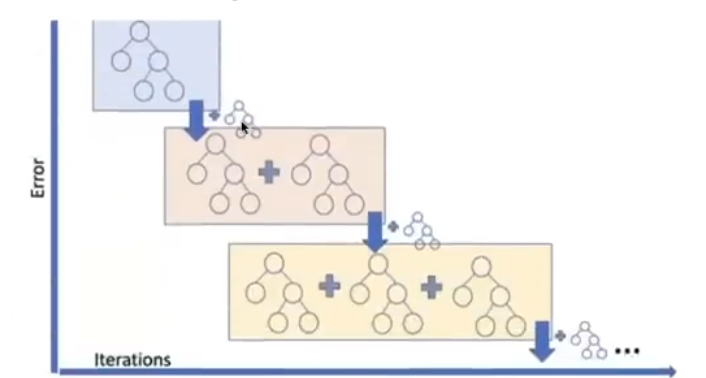
We're ow ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:


1.   The average value of the target column is computed and uses an initial prediction every input.
2.   The residuals(difference) of the predictions with the targets are computed.
3.   A decision tree of limited depth is trained to **predict the residuals** for each input.
4.   Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting).
5.   Scaled predictions for the tree are added to the previous predictions to obtain the new and improved predictions.
6.   Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previuos prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model.

>**EXERCISE**: Can you describe in your own words how a gradient boosting machine is different from random forest?



A gradient boosting model successively improving our predictions by **training small decision trees to correct the error of the model.**

**Alpha** prevents overfitting to the training set i.e. creating some error which can be be filled by the next decision tree to prevent overfitting to the training set.

It is called **boosting** because a new model is trained to correct the errors/improve an existing model as opposed to bagging in Random Forests where each decision tree tries to make the entire prediction.

Boosting means you are improving an existing model i.e. the 2nd decsion tree depend on the 1st decision tree.

It's called **gradient boosting** because the objective is to create new decision trees to minimise loss similar to the iterative gradient boosting machine.

*Gradient boosting machine is a boosting technique which minimize the error by creating new estimators/new decision trees each time.*

## **Training**
To train a **GBM**, we can use the `XGBRegressor` class from the `XGBoost` library.

In [50]:
from  xgboost import XGBRegressor

In [51]:
#?XGBRegressor

In [52]:
model = XGBRegressor(random_state = 42, n_jobs = -1, n_estimators = 20, max_depth =4)

Let's train the model using `model.fit`

**n_estimators:** Tells how many trees you are going to create.

**max_depth:** How deep each tree goes to prevent the unbounded decision tree from exactly fitting the residuals which leads to overfitting the training set to predict the training set.

**Learning Rate(eta):** The scaling down dumping factor that is applied tothe residual prediction from each decision tree to avoid overfitting.

**random_state**:To ensure that the randomization is using 42 as a seed so that each time we run `model.fit`, we get the same results.

**n_jobs**:


In [53]:
%%time
model.fit(x,targets)

CPU times: user 7.9 s, sys: 136 ms, total: 8.03 s
Wall time: 10.3 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

>**EXERCISE:** Explain how the `.fit` method of `XGBRegressor` applies the iterative machine learning workflow to train the model using the training data.

## **Prediction**

We can now make predictions and evaluate the model using `model.predict`.

In [54]:
preds = model.predict(x)

In [55]:
preds

array([8125.5312, 7681.051 , 8257.176 , ..., 8607.603 , 8669.647 ,
       9950.437 ], dtype=float32)

# **Evaluation**

Let's evaluate the predictions using the `RMSE` error.

In [56]:
from sklearn.metrics import mean_squared_error

def rmse(a,b):
  return mean_squared_error(a,b, squared = False)

In [57]:
rmse(preds, targets)

2411.1566024549124

This implies our prediction are off by usd. 2400.

In [58]:
 merged_df.Sales.min(), merged_df.Sales.max()

(0, 41551)

(array([6.100e+02, 4.944e+03, 3.194e+03, 8.780e+02, 2.540e+02, 7.100e+01,
        2.700e+01, 1.300e+01, 8.000e+00, 1.000e+00]),
 array([    0. ,  3365.5,  6731. , 10096.5, 13462. , 16827.5, 20193. ,
        23558.5, 26924. , 30289.5, 33655. ]),
 <BarContainer object of 10 artists>)

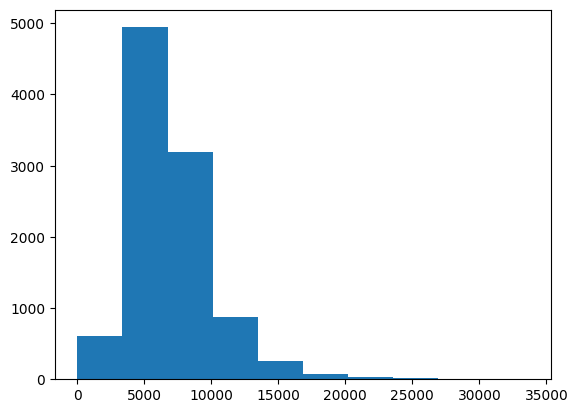

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(merged_df.Sales.sample(10000))

Going by the histogram, most of the sales are in the range 5000 to 100000 and we are off by 2400 hence not that bad as compared to say 10000.

## **Visualization**

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed).

In [60]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize']=30,30

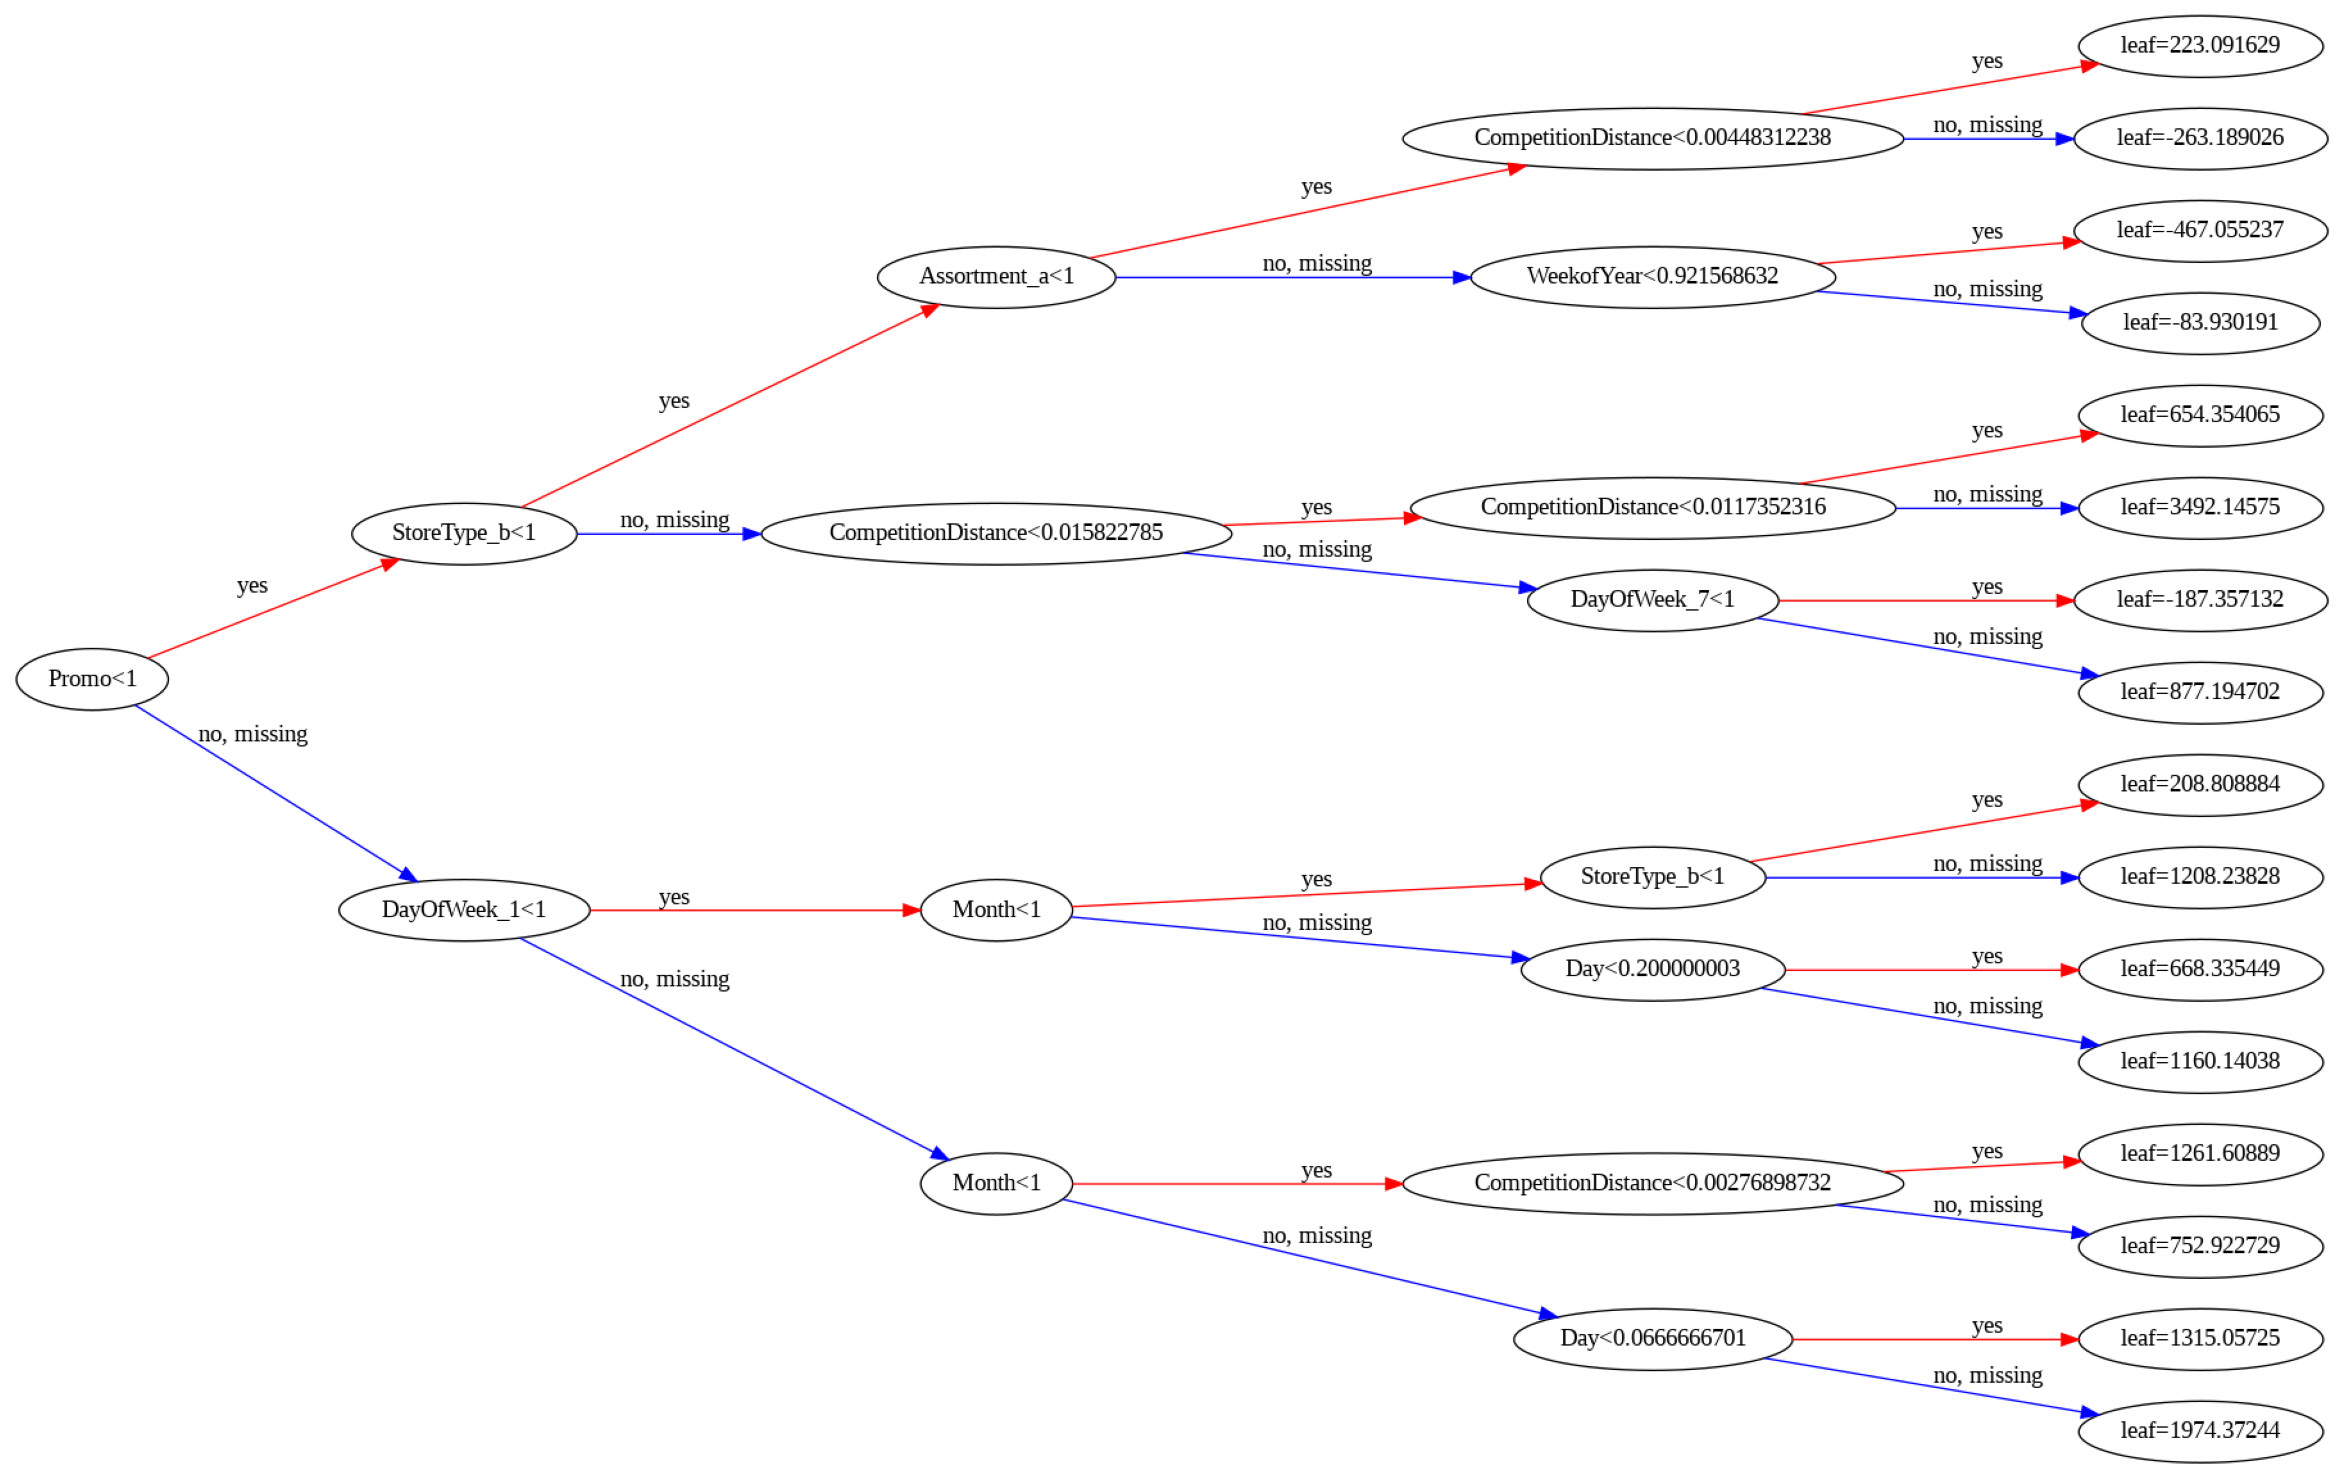

In [61]:
plot_tree(model, rankdir = 'LR');

THe values on the leaf nodes are not predictions for the actual sales but the deviations from the average we are predicting.

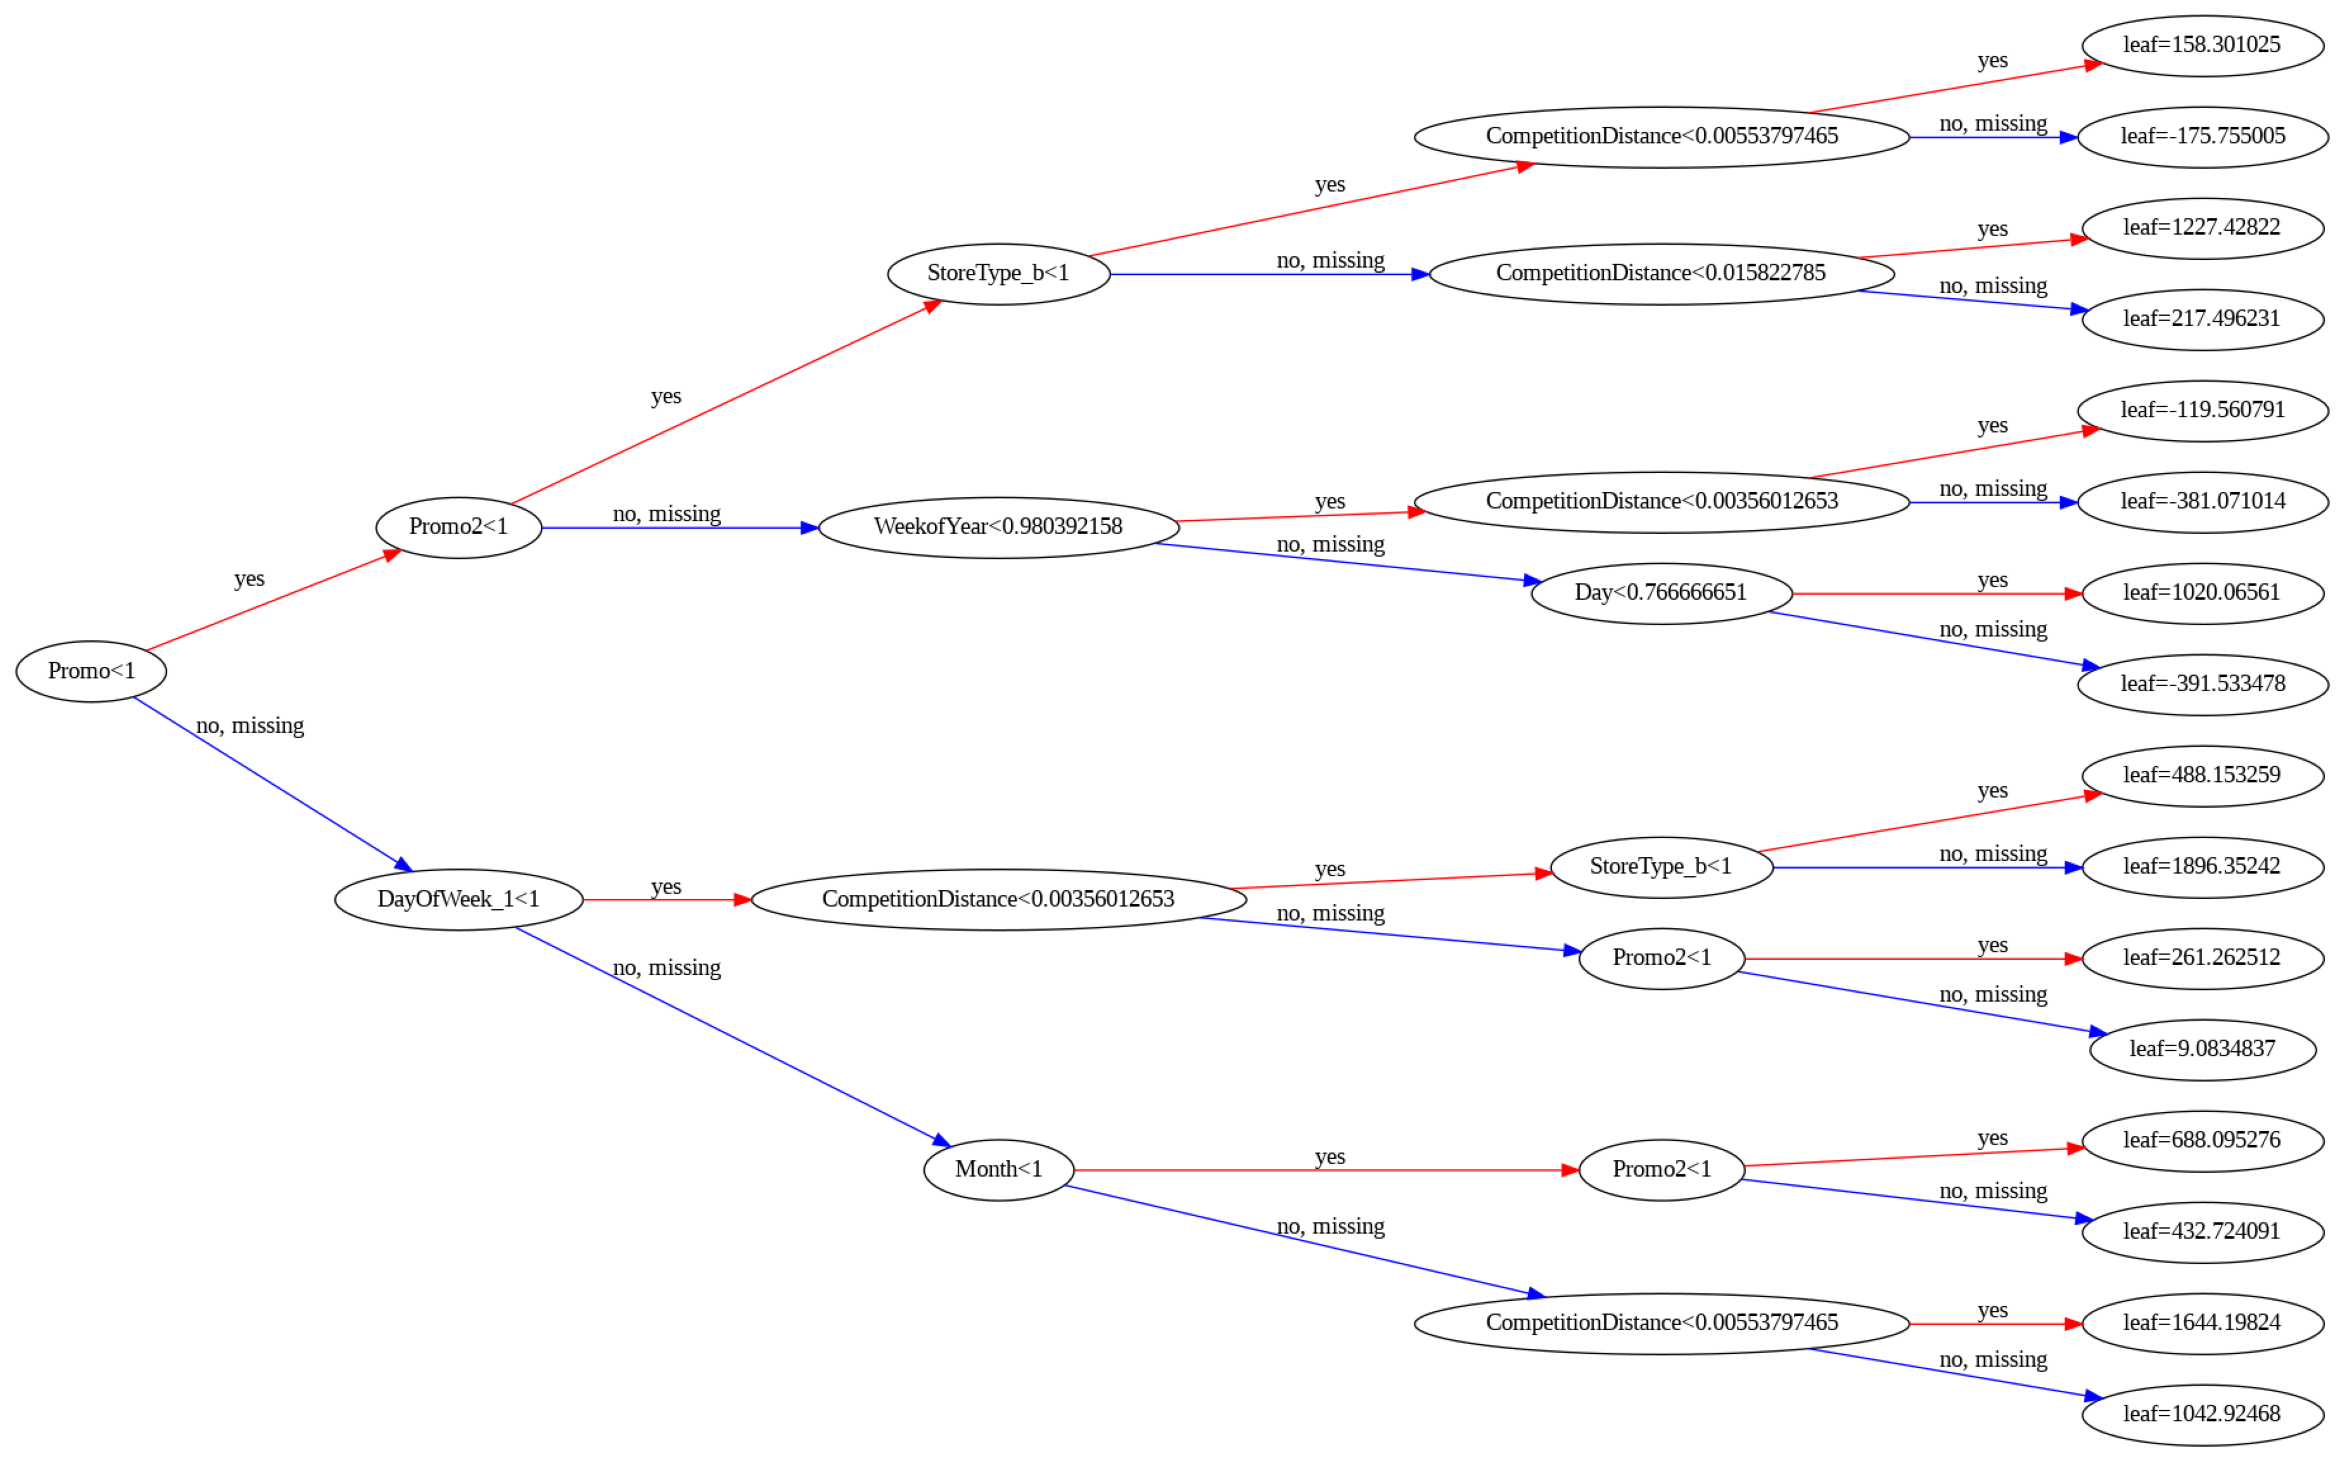

In [62]:
plot_tree(model, rankdir = 'LR', num_trees=1);#tree number zero

This correct the residuals that remain after adding the 1st tree.

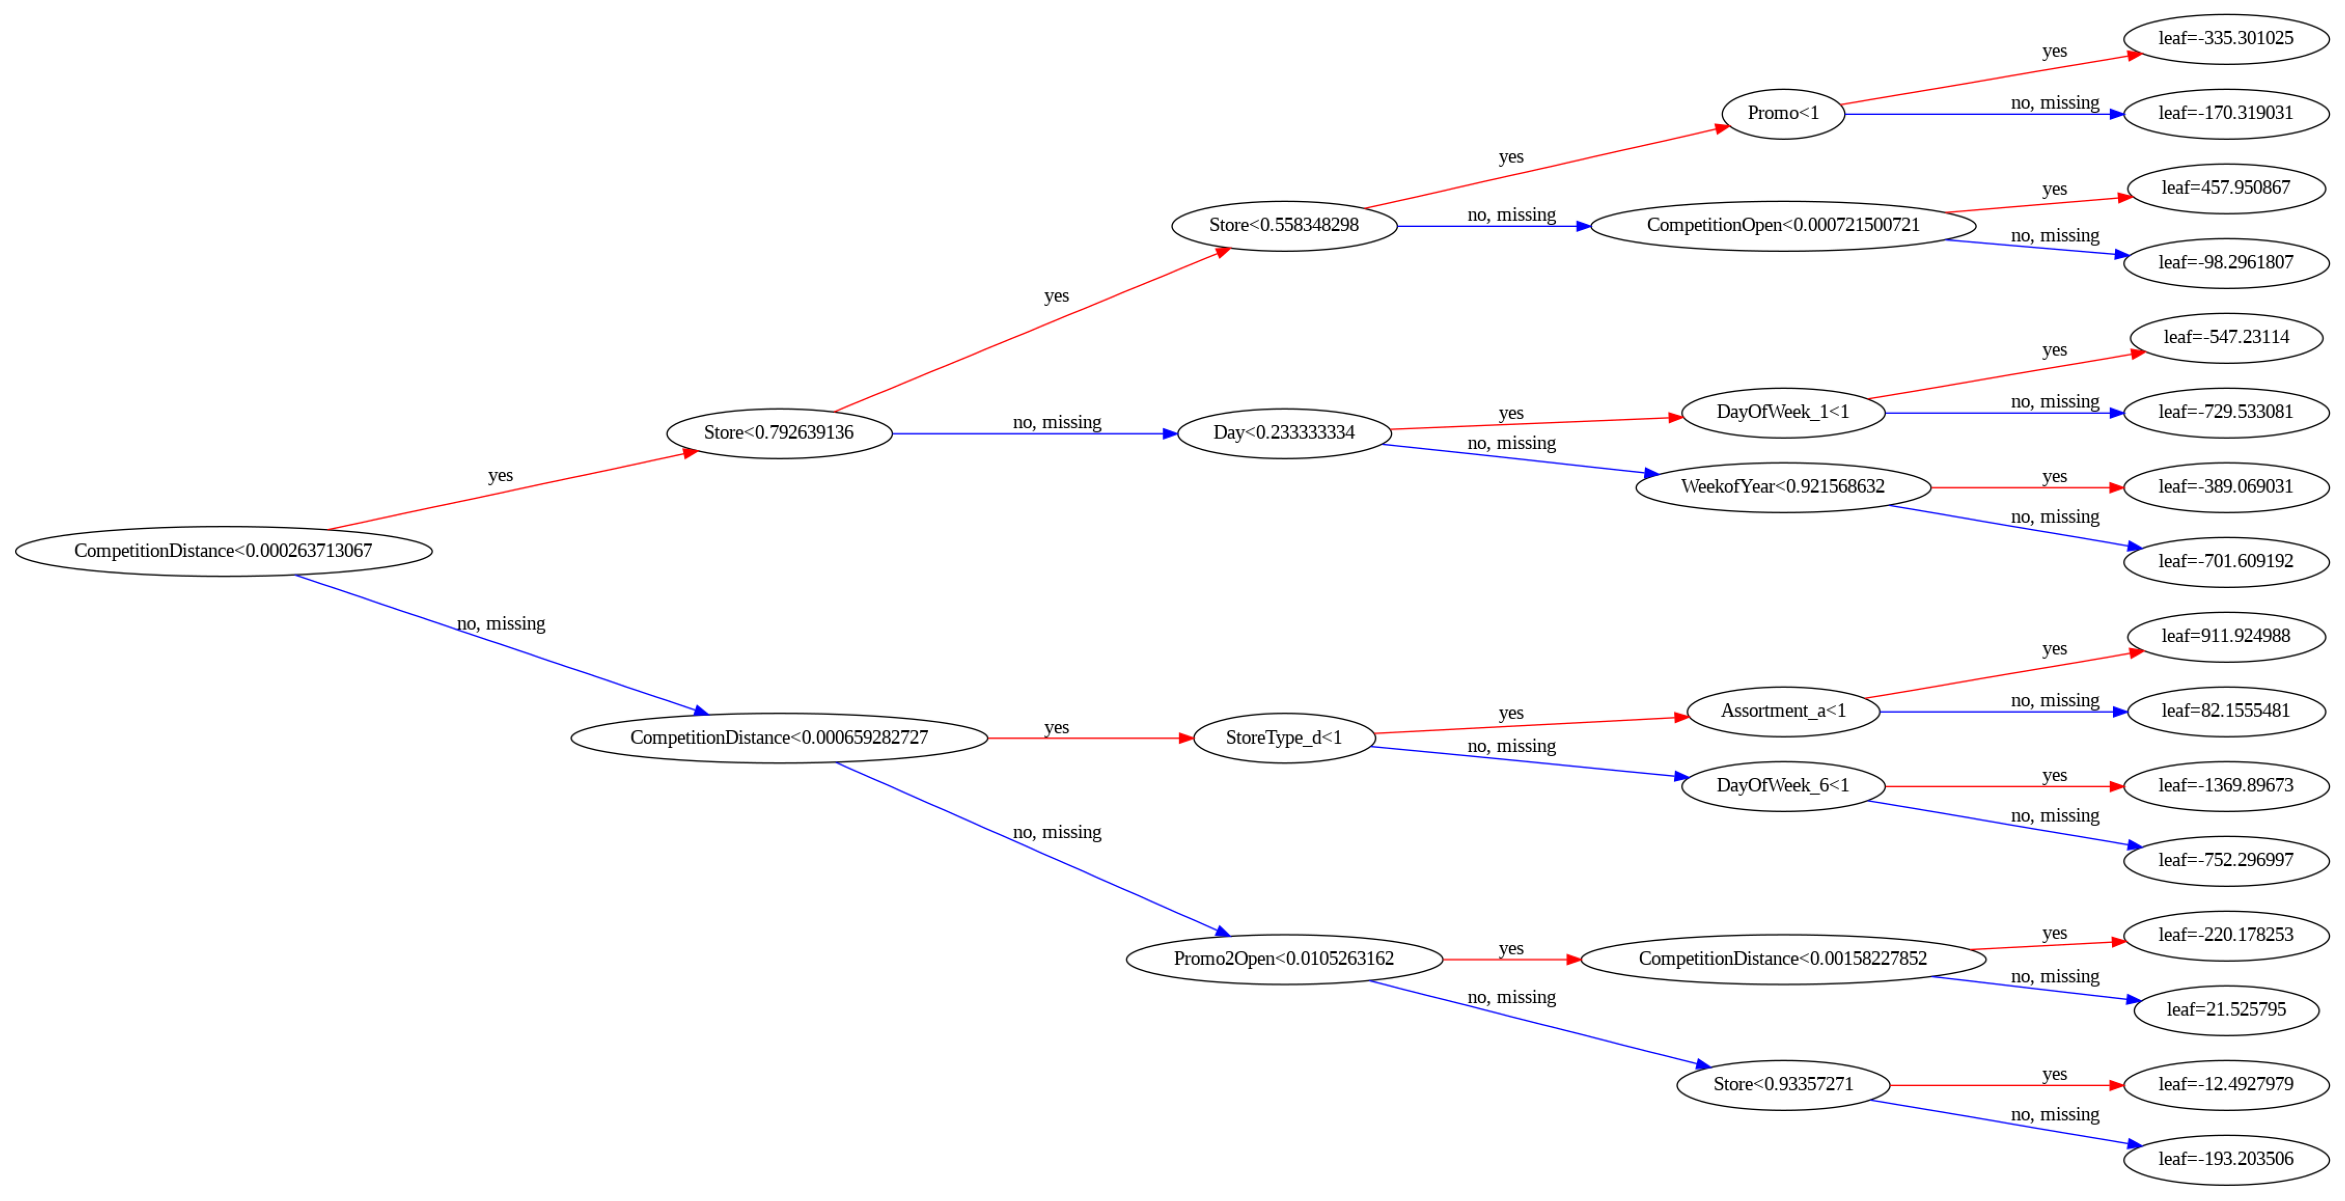

In [63]:
plot_tree(model, rankdir = 'LR', num_trees=19);#tree number 19

The final tree that correct the errors of the sum of all the first 18 trees and the average and the numbers are much smaller as compared to the earlier ones hence an improvement in the results.

Notice how the trees only compute residuals, and not the actual target value. We can also visualize the tree as text.

In [64]:
trees = model.get_booster().get_dump()

In [65]:
len(trees)

20

In [66]:
print(trees[0])

0:[Promo<1] yes=1,no=2,missing=2
	1:[StoreType_b<1] yes=3,no=4,missing=4
		3:[Assortment_a<1] yes=7,no=8,missing=8
			7:[CompetitionDistance<0.00448312238] yes=15,no=16,missing=16
				15:leaf=223.091629
				16:leaf=-263.189026
			8:[WeekofYear<0.921568632] yes=17,no=18,missing=18
				17:leaf=-467.055237
				18:leaf=-83.930191
		4:[CompetitionDistance<0.015822785] yes=9,no=10,missing=10
			9:[CompetitionDistance<0.0117352316] yes=19,no=20,missing=20
				19:leaf=654.354065
				20:leaf=3492.14575
			10:[DayOfWeek_7<1] yes=21,no=22,missing=22
				21:leaf=-187.357132
				22:leaf=877.194702
	2:[DayOfWeek_1<1] yes=5,no=6,missing=6
		5:[Month<1] yes=11,no=12,missing=12
			11:[StoreType_b<1] yes=23,no=24,missing=24
				23:leaf=208.808884
				24:leaf=1208.23828
			12:[Day<0.200000003] yes=25,no=26,missing=26
				25:leaf=668.335449
				26:leaf=1160.14038
		6:[Month<1] yes=13,no=14,missing=14
			13:[CompetitionDistance<0.00276898732] yes=27,no=28,missing=28
				27:leaf=1261.60889
				28:leaf=752.9

# **Feature importance**

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [67]:
importance_df = pd.DataFrame({
    'feature':x.columns,
    'importance':model.feature_importances_
}).sort_values('importance', ascending = False)


In [68]:
importance_df.head(10)

,feature,importance
1,Promo,0.353834
12,DayOfWeek_1,0.073732
24,StoreType_b,0.072635
5,Promo2,0.058180
26,StoreType_d,0.046162
3,CompetitionDistance,0.040557
29,Assortment_c,0.034315
27,Assortment_a,0.033658
6,Promo2Open,0.030316
9,Month,0.029576


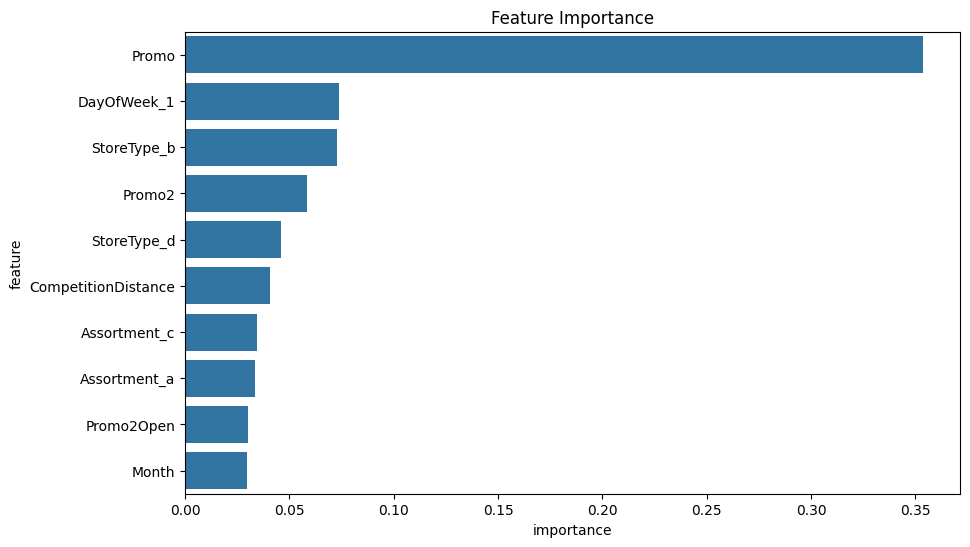

In [69]:
import seaborn as sns
plt.figure(figsize = (10,6))
plt.title('Feature Importance')
sns.barplot(data = importance_df.head(10), x='importance', y = 'feature');

# K-Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different valiadtion strategy this time, called K-fold cross validation.

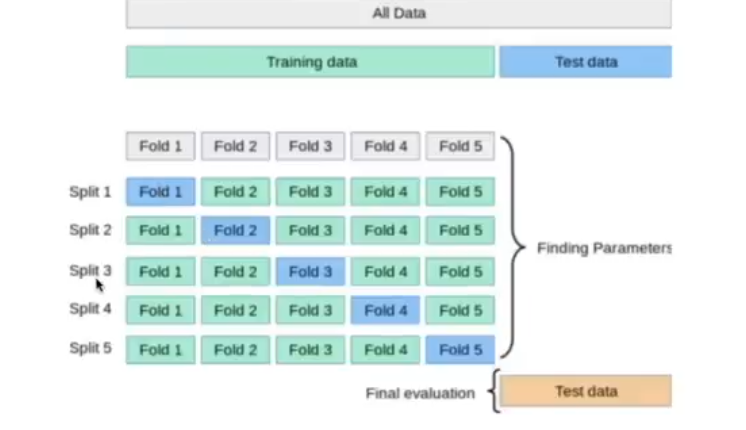

We didn't create a validation set because we want to use a different validation strategy - K-Fold Validation.

We take our training data and we split it into many parts i.e. 5 folds/parts. Each time we train 5 different models and for each model we use a diffrent fold as validation set i.e. the first 20% as validation set for 1st split and for the second split, use the 2nd 20% as the validation set upto the 5th split. It is used for hyperparameter tuning.

The advantage is that we are not sacrificing any data for training, all data is used. We are to look at the validation score for each of the splits.

Useful for small datasets and not large ones.

 For this case of time ordered data, the validation set should be in the future of the training set.



Scikit-learn provides utilities for performing K fold cross validation.

In [70]:
from sklearn.model_selection import KFold

Let's define a helper function `train_and _evaluate` which trains a model the given parameters and returns the trained model, training, error and validation error.


In [71]:
def train_and_evaluate(x_train, train_targets, x_val, val_targets, **params):
  model = XGBRegressor(random_state =42, n_jobs=-1, **params)
  model.fit(x_train, train_targets)
  train_rmse = rmse(model.predict(x_train), train_targets)
  val_rmse = rmse(model.predict(x_val),val_targets)
  return model, train_rmse, val_rmse

Now, we can use the `KFold` utility to create the different training/validation splits and train a separate model for each fold.

In [72]:
kfold = KFold(n_splits = 5, shuffle = True)##You can also shuffle

When you a small dataset, split the data 5 ways and then use 20% each time for the validation and train the model for each of the splits and then average the results for all the models.

In [73]:
models  = []

for train_idxs, val_idxs in kfold.split(x):
  x_train, train_targets = x.iloc[train_idxs], targets.iloc[train_idxs]
  x_val, val_targets = x.iloc[val_idxs], targets.iloc[val_idxs]
  model, train_rmse, val_rmse = train_and_evaluate(x_train,
                                                   train_targets,
                                                   x_val,
                                                   val_targets,
                                                   max_depth = 4,
                                                   n_estimators = 20)
  models.append(model)
  print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 2394.1897040729646, Validation RMSE: 2396.6535788600286
Train RMSE: 2387.5185737573856, Validation RMSE: 2378.8006138399787
Train RMSE: 2433.8217431348385, Validation RMSE: 2437.2541870076234
Train RMSE: 2399.0291244169107, Validation RMSE: 2406.5724171603415
Train RMSE: 2387.3431999610684, Validation RMSE: 2389.4746151548316


Let's also define a function to average predictions from the 5 different models.

In [74]:
import numpy as np

def predict_avg(models, inputs):
  return np.mean([model.predict(inputs) for model in models], axis =0)

In [75]:
(models[0].predict(x)+models[1].predict(x)+models[2].predict(x)+models[3].predict(x)+models[4].predict(x))/5

array([7934.4424, 7252.9873, 8070.329 , ..., 7889.249 , 8575.816 ,
       9808.135 ], dtype=float32)

In [76]:
preds = predict_avg(models, x)

In [77]:
preds

array([7934.4424, 7252.9873, 8070.329 , ..., 7889.249 , 8575.816 ,
       9808.135 ], dtype=float32)

We can now use `predict_avg` to make predictions for the test set.

# **Hyperparameter Tuning and Regularization**

There are several hyperparameters we can do to adjust the capacity of the model and reduce overfitting.

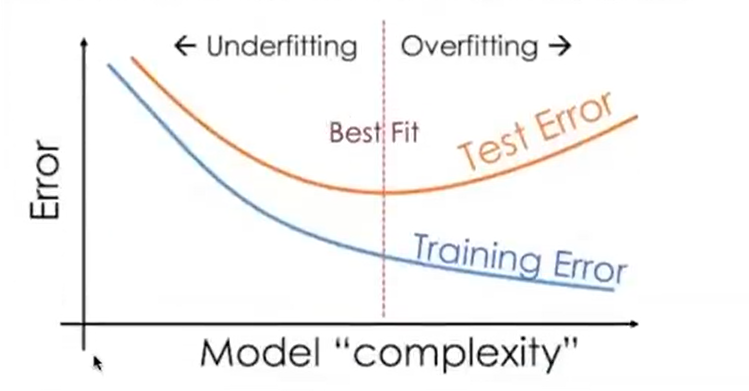

In [78]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [79]:
#?XGBRegressor

Here's is a helper function to test hyperparameters with K-fold cross validation.

In [80]:
def test_params_kfold(n_splits, **params):
  train_rmses, val_rmses, models = [], [], []
  kfold = KFold(n_splits)
  for train_idxs, val_idxs in kfold.split(x):
    x_train, train_targets = x.iloc[train_idxs], targets.iloc[train_idxs]
    x_val, val_targets = x.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(x_train, train_targets, x_val, val_targets, **params)
    models.append(model)
    train_rmses.append(train_rmse)
    val_rmses.append(val_rmse)
  print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses),np.mean(val_rmses)))
  return models


Since it may take a long time to perform 5-fold cross validation for each set of parameters we wish to try, we will just pick a random 10% sample of the dataset as validation set.

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
x_train, x_val, train_targets, val_targets = train_test_split(x, targets, test_size = 0.1)

In [83]:
def test_params(**params):
  model = XGBRegressor(n_jobs=-1, random_state = 42, **params)
  model.fit(x_train, train_targets)
  train_rmse = rmse(model.predict(x_train), train_targets)
  val_rmse = rmse(model.predict(x_val), val_targets)
  print('Train RMSE: {}, Validation RMSE{}'.format(train_rmse, val_rmse))

## **n_estimators**

THe number of trees to be created. More trees = greater capacityof the model.

In [84]:
test_params(n_estimators = 10)

Train RMSE: 2317.3443272712416, Validation RMSE2335.9559565554628


In [85]:
test_params(n_estimators = 30)

Train RMSE: 1864.0700181307118, Validation RMSE1879.5830906798676


In [86]:
test_params(n_estimators = 100)

Train RMSE: 1179.7570295360838, Validation RMSE1193.2212674711907


When checking where to stop, also check the run time and overfitting.
i.e. if `n_estimators`=240 takes longer than `n_estimators`=100 then you might consider taking `n_estimators` = 100.

In [87]:
test_params(n_estimators = 240)

Train RMSE: 901.3979589042052, Validation RMSE921.5025437106464


>**EXERCISE**: Experiment with different values of `n_estimators`, plot a graph of the training and validation error and determine the best value for n_estimators.
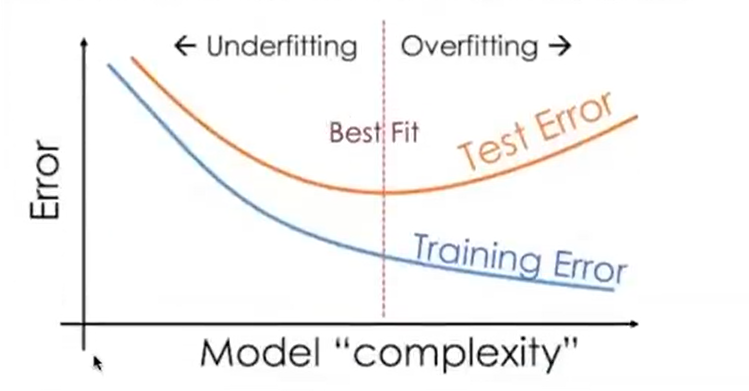

## **max_depth**

As you increase the `max_depth` of each tree, capacity of tree increases and it can capture more information about the training set.

As we increase the `max_depth` the loss goes down

In [88]:
test_params(max_depth = 2, n_estimators=10)

Train RMSE: 2686.4146515964267, Validation RMSE2688.507236993875


In [89]:
test_params(max_depth=5, n_estimators=10)

Train RMSE: 2455.5035168088484, Validation RMSE2467.369277119601


In [90]:
test_params(max_depth = 10, n_estimators=10)

Train RMSE: 1910.4581695632758, Validation RMSE1947.557619413668


Keep increasing the `max_depth` till you start seeing some overfitting happening.

>**EXERCISE**: Experiment with different values of `max_depth`, plot a graph of the training and validation error and determine the optimal.
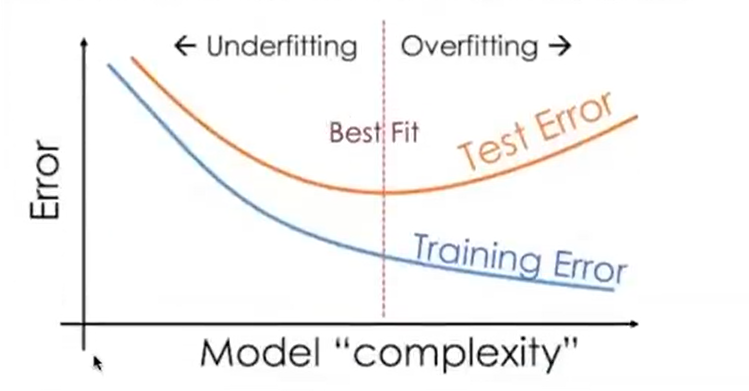

`Overfitting`: **Refers to a scenario where the training error is decreasing as you increase the model's complexity but at the same time the validation error is increasing. So the model is getting worse at the validation set even though it is getting better at the training set.**

## **Learning rate**

The scaling factor to be applied to the prediction of each tree. A very high learning rate(close to 1) will lead to overfittiing and a low learning rate(close to 0) will lead to underfitting.

This is the alpha that is applied to the predictions to scale the predictions of every tree.

*A very low learning_rate like 0.1 will lead to underfitting and a very high learning rate like 0.99 may lead to overfitting because you have other regularizing hyperparameters as well.*

*Low learning rate  low power because you are not giving the decision trees much weight in the predictions
High learning rate - higher power hence likelihood of overfitting.*

In [91]:
test_params(n_estimators = 50, learning_rate = 0.01)

Train RMSE: 2787.876665451735, Validation RMSE2791.980328927895


In [92]:
test_params(n_estimators = 50, learning_rate = 0.1)

Train RMSE: 2195.694679443877, Validation RMSE2213.7308235866835


In [93]:
test_params(n_estimators = 50, learning_rate = 0.3)

Train RMSE: 1517.9064190917047, Validation RMSE1532.3623478214613


In [94]:
test_params(n_estimators = 50, learning_rate = 0.9)

Train RMSE: 1164.1367839446516, Validation RMSE1177.2685721943462


In [95]:
test_params(n_estimators = 50, learning_rate = 0.99)

Train RMSE: 1153.7153331793309, Validation RMSE1169.1117673313718


Always start with the hyperparameters that will have the highest effect i.e. `n_estimators`, then pick the most next impactful one( figure out by trying on any 2 random parameters) then max_deth, learning rate.

>**EXERCISE**:Experiment with different values of `learning_rate`. Plot a graph of the training and validation error and determine the optimal.

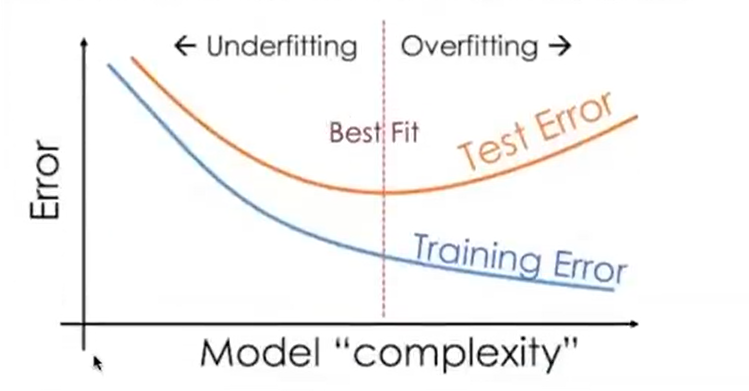

### **booster**

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using a `booster`.

In [96]:
test_params(booster = 'gblinear')

Train RMSE: 2727.8986142322, Validation RMSE2734.8095400466186


 Clearly a linear model is not well suited for this dataset.

> **EXERCISE**: Experiment with other hyperparameters like `gamma`, `min_child_weight`, `max_delta_step`, `subsample`, `colsample_bytree` etc. and find their optimal values.

`gamma`  - What is the minimum reduction in loss tha is required to create a split.
`min_child_weight`  - What percent of rows each child should contain.
`max_delta_step` -
`subsample` - Instead of using all the rows, use a fraction of the rows.
`colsample_bytree` - For each tree that you create, instead of using all the columns, use a fraction of the columns randomly chosen to create randomization.


> **EXERCISE:** Train a model with your best hyperparameters and evaluate its performance using 5-fold cross-validation.

*It is common practice that you have a validation set or do cross validation.*

# **Putting it Together and Making Predictions**

Let's train a final model on the entire training set with custom hyperparameters

In [97]:
model = XGBRegressor(n_jobs = -1, random_state = 42, n_estimators = 1000,
                     learning_rate = 0.2, max_depth = 10, subsample  =0.9,
                     colsample_bytree = 0.7)

It's common practice you will have a validation set/cross validation and you will try different experiments find the best.

**At the very end, you can train the model on the entire training set including the validation set, now that we have done evaluating different models and decided which hyperparameters work well for this dataset. Train with the entire set and get a final boost because more data is always helpful for the model and then make predictions on the test set.**

**Have a validation set, use it till the very end, but when you are making predictions, just train the model with the entire set.**


In [98]:
%%time
model.fit(x,targets)

CPU times: user 4min 5s, sys: 760 ms, total: 4min 5s
Wall time: 2min 23s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [99]:
train_preds = model.predict(x)##issue
rmse(train_preds, targets)

382.4475440240041

Now the model is trained, we can make predictions on the test set.

In [100]:
x_test

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekofYear,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.000000,1.0,0.0,0.016482,0.060606,0.0,0.000000,0.0,0.533333,0.727273,1.0,0.725490,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.001795,1.0,0.0,0.186050,0.075758,1.0,0.757895,0.0,0.533333,0.727273,1.0,0.725490,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.005386,1.0,0.0,0.316192,0.020924,0.0,0.000000,0.0,0.533333,0.727273,1.0,0.725490,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.006284,1.0,0.0,0.098892,0.007937,0.0,0.000000,0.0,0.533333,0.727273,1.0,0.725490,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.007181,1.0,0.0,0.026503,0.130592,0.0,0.000000,0.0,0.533333,0.727273,1.0,0.725490,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,0.996409,0.0,0.0,0.024789,0.010101,1.0,0.252632,0.0,0.000000,0.636364,1.0,0.588235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
41084,0.997307,0.0,0.0,0.024525,0.080808,0.0,0.000000,0.0,0.000000,0.636364,1.0,0.588235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
41085,0.998205,0.0,0.0,0.121835,0.000000,0.0,0.000000,0.0,0.000000,0.636364,1.0,0.588235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
41086,0.999102,0.0,0.0,0.011208,0.000000,0.0,0.000000,0.0,0.000000,0.636364,1.0,0.588235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [101]:
test_preds = model.predict(x_test)

In [102]:
test_preds

array([ 3711.0247,  8154.7725,  9057.335 , ...,  6487.5312, 23420.717 ,
        7228.942 ], dtype=float32)

In [103]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [104]:
submission_df

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
41083,41084,0
41084,41085,0
41085,41086,0
41086,41087,0


Let's add the predictions in to `submission_df`.

In [105]:
submission_df['Sales']  =test_preds

In [106]:
submission_df

,Id,Sales
0,1,3711.024658
1,2,8154.772461
2,3,9057.334961
3,4,6889.365723
4,5,6814.767578
...,...,...
41083,41084,3705.848145
41084,41085,8152.156250
41085,41086,6487.531250
41086,41087,23420.716797


Recall, however, that if the store is not open, then the sales must be 0. Thus, wherever the value of `open` in the test set is 0, we can set the sales to 0. Also, there some missing values for `open` in the test set. We'll replace them with 1 (open)

In [107]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [108]:
test_df.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [109]:
submission_df['Sales']=submission_df['Sales']*test_df.Open.fillna(1.)

In [110]:
submission_df

,Id,Sales
0,1,3711.024658
1,2,8154.772461
2,3,9057.334961
3,4,6889.365723
4,5,6814.767578
...,...,...
41083,41084,3705.848145
41084,41085,8152.156250
41085,41086,6487.531250
41086,41087,23420.716797


In [111]:
submission_df.sample(20)

,Id,Sales
37606,37607,7666.670410
25317,25318,12834.754883
20640,20641,7868.233887
25661,25662,11050.197266
15212,15213,8017.906738
36214,36215,6030.586426
15311,15312,14317.101562
39324,39325,11182.990234
24586,24587,5825.092773
18049,18050,4746.121094


We can now save the predictions as a CSV file.

In [112]:
submission_df.to_csv('submission.csv',index='True')

>**EXERCISE**: Save the model and all the other required objects using `joblib`.

>**EXERCISE**:Write a function `predict_input` which can make predictions for a single input provided as a dictionary. Make sure to include all the feature engineering and preprocessing steps.

In [165]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [166]:
sample_input = {
    'Store':2,
    'DayOfWeek':4,
    'Promo': 1,
    'Date':'2015-09-30',
    'Open': 1,
    'StateHoliday':'a',
    'SchoolHoliday':0
}

In [167]:
input_df  = pd.DataFrame([sample_input])
input_df

,Store,DayOfWeek,Promo,Date,Open,StateHoliday,SchoolHoliday
0,2,4,1,2015-09-30,1,a,0


In [168]:
# Merge with stores_df
input_merged_df = input_df.merge(store_df, on = 'Store')

In [169]:
input_merged_df

,Store,DayOfWeek,Promo,Date,Open,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2,4,1,2015-09-30,1,a,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [170]:
# Feature Engineering
# Dates
split_date(input_merged_df)
# Competition
comp_months(input_merged_df)
# Promo2
promo_cols(input_merged_df)
input_merged_df

,Store,DayOfWeek,Promo,Date,Open,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekofYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,2,4,1,2015-09-30,1,a,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,9,30,40,94.0,87.0,0


In [171]:
# Preprocessing
# Imputation - not required
# Scaling
input_merged_df[numeric_cols] =scaler.transform(input_merged_df[numeric_cols ])
# Encoding
input_merged_df[encoded_cols]=encoder.transform(input_merged_df[categorical_cols])



In [173]:
# Selecting the right columns (numerical + categorical columns)
x_input = input_merged_df[numeric_cols+encoded_cols]
# Pass it into the model
model.predict(x_input)[0]

7790.209

**LightGBM** is another similar method that implement tree based models and gradient boosting.